In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from tqdm import tqdm
from torchvision.models import ResNet18_Weights


import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from learn import CustomCircleDataset,SimpleCNN,SimpleCNN_1,CustomResNet


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_path = '../generate/image/dataset/paste'
# 'path_to_dataset'をデータセットのパスに置き換えてください。
dataset = CustomCircleDataset('../generate/image/dataset/paste', transform=transform)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# データセットの全サイズ
total_size = len(dataset)

# 各データセットのサイズを計算
train_size = int(total_size * 0.7)
val_size = int(total_size * 0.2)
test_size = total_size - train_size - val_size

# データセットをランダムに分割
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaderを作成
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [3]:
len(dataset)

50625

In [4]:
# model = SimpleCNN()
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# モデルをデバイスに移動

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Epoch 1/20: 100%|██████████| 554/554 [02:00<00:00,  4.58batch/s]


Epoch [1/20], Train Loss: 0.0241, Val Loss: 0.0084


Epoch 2/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [2/20], Train Loss: 0.0078, Val Loss: 0.0052


Epoch 3/20: 100%|██████████| 554/554 [02:01<00:00,  4.57batch/s]


Epoch [3/20], Train Loss: 0.0059, Val Loss: 0.0065


Epoch 4/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [4/20], Train Loss: 0.0048, Val Loss: 0.0051


Epoch 5/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [5/20], Train Loss: 0.0042, Val Loss: 0.0030


Epoch 6/20: 100%|██████████| 554/554 [01:59<00:00,  4.62batch/s]


Epoch [6/20], Train Loss: 0.0038, Val Loss: 0.0045


Epoch 7/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [7/20], Train Loss: 0.0036, Val Loss: 0.0023


Epoch 8/20: 100%|██████████| 554/554 [02:01<00:00,  4.58batch/s]


Epoch [8/20], Train Loss: 0.0034, Val Loss: 0.0022


Epoch 9/20: 100%|██████████| 554/554 [02:00<00:00,  4.58batch/s]


Epoch [9/20], Train Loss: 0.0030, Val Loss: 0.0025


Epoch 10/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [10/20], Train Loss: 0.0029, Val Loss: 0.0034


Epoch 11/20: 100%|██████████| 554/554 [02:01<00:00,  4.57batch/s]


Epoch [11/20], Train Loss: 0.0029, Val Loss: 0.0014


Epoch 12/20: 100%|██████████| 554/554 [02:00<00:00,  4.59batch/s]


Epoch [12/20], Train Loss: 0.0025, Val Loss: 0.0016


Epoch 13/20: 100%|██████████| 554/554 [02:01<00:00,  4.57batch/s]


Epoch [13/20], Train Loss: 0.0024, Val Loss: 0.0039


Epoch 14/20: 100%|██████████| 554/554 [02:00<00:00,  4.58batch/s]


Early stopping at epoch 14
Test Loss: 0.0021


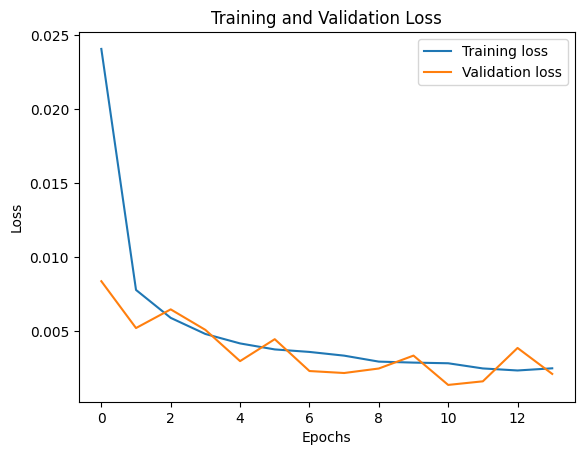

In [5]:

num_epochs = 20
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 3
trigger_times = 0

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        # データをGPUに移動
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # バリデーションループ
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # 平均損失を計算
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)  # 訓練損失をリストに追加
    val_losses.append(val_loss)

    # 最良モデルの保存と早期終了の処理
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.to('cpu').state_dict(), 'best_model.pth')
        model.to(device)
        trigger_times = 0  # 改善されたのでカウンターをリセット
    else:
        trigger_times += 1  # 改善されないのでカウンターを増やす
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# テストループ
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

# 平均テスト損失の計算と表示
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')


# 学習結果のグラフを表示
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
torch.save(model.to('cpu').state_dict(), 'weeight/simpleCNN_1.pth')

In [ ]:
def infer(model, image_path, device):
    """
    推論を行う関数。

    Args:
    model (torch.nn.Module): トレーニング済みのモデル。
    image_path (str): 推論を行いたい画像のパス。
    device (torch.device): モデルとデータを置くデバイス（例: 'cuda' or 'cpu'）。

    Returns:
    tuple: 推論によって得られた中心座標(x, y)。
    """
    model.eval()  # モデルを評価モードに設定
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # 画像をロードして前処理
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():  # 勾配計算を無効化
        outputs = model(image)
        predicted_coords = outputs.cpu().numpy()[0]  # デバイスからCPUへ

    # 座標のスケーリング（出力を元の画像サイズに合わせる）
    x, y, r = predicted_coords[0] * 224, predicted_coords[1] * 224, predicted_coords[2] * 224 * 1.414
    return x, y, r


In [ ]:
infer(model,'../generate/image/dataset/paste/double/1.0_96_157_60_cbbfe2d5-15f2-45af-b019-d853c8fda910.png','cpu')

In [ ]:
model = SimpleCNN()  # SimpleCNNのインスタンスを作成
model.load_state_dict(torch.load('model_2.pth'))
model.eval()  # 推論モードに設定

In [ ]:
import cv2
def apply_hsv_threshold(image):
    low_h, high_h = 91, 103  # Example range for yellow hue
    low_s, high_s = 200, 255 # Example range for saturation
    low_v, high_v = 140, 255 # Example range for value
    
    # Convert the image from RGB to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Define the lower and upper bounds of the HSV threshold
    lower_bound = np.array([low_h, low_s, low_v])
    upper_bound = np.array([high_h, high_s, high_v])
    
    # Create a mask where pixels within the threshold are white, and others are black
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)
    
    # Create an all black image
    black_image = np.zeros_like(image)
    
    # Copy the pixels from the original image where the mask is white
    result_image = np.where(mask[:, :, None] == 255, image, black_image)
    
    return result_image

img_path = '../generate/image/dataset/paste/simple/0.45_40_167_27_d378c0ea-3a05-4ace-82b9-1bcf5b706ef8.png'
image = cv2.imread(img_path)
image = apply_hsv_threshold(image)
    
pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
image = transform(pil_image).unsqueeze(0)

# モデルを使用して予測
with torch.no_grad():
    outputs = model(image)
    predicted_coords = outputs.cpu().numpy()[0]
    pos_x, pos_y, pos_r = predicted_coords


# 座標と半径をスケーリング
    pos_x = int(pos_x * 224)
    pos_y = int(pos_y * 224)
    pos_r = int(pos_r * (224)* 1.414)